# Introduction:

Stack Exchange hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and data science! Here's a sample of the most popular sites:

Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

I am pretty familiar with Stack Exchange, but lets answer a few questions that some may have:

- What kind of questions are welcome on Stack Exchange?
    - questions that are on-topic and unduplicated to that particular subgroup on stack exchange
- What, other than questions, does the site's home subdivide into?
    - tags, other communties, etc

After a spending some time investigating the website, you decide that the tags will be very useful in categorizing content, saving you the trouble of you having to do it yourself.

Stack Exchange provides a public data base for each of its websites. [Here's](https://data.stackexchange.com/datascience/query/new) a link to query and explore Data Science Stack Exchange's database.

# Part 1: Initial Data Exploration & Understanding the data

We can see the data model here that we are reviewing:

![SE](https://i.stack.imgur.com/AyIkW.png)

The data model is made up of multiple tables based on the user, the users interactions in the sub-community, posts, and tags reference system.

Tables that look promising:
- Posts
- Tags
- Comments
- Votes

There are eight different types of post. Before we try to figure out which of them are relevant to us, let's check how many of them there are:

| PostTypeId | N_of_Posts |
| --- | --- |
| 1| 33546|
| 2 | 36827 |
| 4 | 322 |
| 5 | 322 |
| 6 | 11 |
| 7 | 1 |


Run a query against the SEDE DSSE database that extracts the columns listed above for all the questions in 2019:

Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
"44419","1","2019-01-23 09:21:13","1","21","<machine-learning><data-mining>","0",""
"44420","1","2019-01-23 09:34:01","0","25","<machine-learning><regression><linear-regression><regularization>","0",""
"44423","1","2019-01-23 09:58:41","2","1651","<python><time-series><forecast><forecasting>","0",""
"44427","1","2019-01-23 10:57:09","0","55","<machine-learning><scikit-learn><pca>","1",""
"44428","1","2019-01-23 11:02:15","0","19","<dataset><bigdata><data><speech-to-text>","0",""
</speech-to-text></data></bigdata></dataset></pca></scikit-learn></machine-learning></forecasting></forecast></time-series></python></regularization></linear-regression></regression></machine-learning></data-mining></machine-learning>

In [1]:
import pandas as pd
df = pd.read_csv('QueryResults.csv')
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,55869,1,2019-07-17 21:51:57,1,50,<scikit-learn><random-forest>,0,NaN
1,55876,1,2019-07-17 23:40:17,2,113,<machine-learning><data-mining><text-mining><nlp>,0,NaN
2,55877,1,2019-07-17 23:57:25,0,105,<beginner><missing-data><definitions>,1,NaN
3,55879,1,2019-07-18 00:31:19,2,108,<data-cleaning><csv>,2,NaN
4,55887,1,2019-07-18 05:46:20,1,47,<machine-learning><deep-learning><tensorflow><...,0,1.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758 entries, 0 to 6757
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             6758 non-null   int64  
 1   PostTypeId     6758 non-null   int64  
 2   CreationDate   6758 non-null   object 
 3   Score          6758 non-null   int64  
 4   ViewCount      6758 non-null   int64  
 5   Tags           6758 non-null   object 
 6   AnswerCount    6758 non-null   int64  
 7   FavoriteCount  1751 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 422.5+ KB


In [3]:
missing_count_dict = {}
for c in df.columns:
    missing_count_dict[c] = df[c].isna().sum()
missing_count_dict

{'Id': 0,
 'PostTypeId': 0,
 'CreationDate': 0,
 'Score': 0,
 'ViewCount': 0,
 'Tags': 0,
 'AnswerCount': 0,
 'FavoriteCount': 5007}

- How many missing values are there in each column?
    - 6758
- Can we fix the missing values somehow?
    - The only column missing data is the `FavoriteCount` column. Because 5007/6758 rows are missing values we can't delete or filter for non-null values in this column, we would lose a lot of data. Possible options of immuting null values based averages from Score or PostType.

- Are the types of each column adequate?
    - `CreationDate` should be a datetime obj. Other column data types are good.

- What can we do about the Tags column?
    - The tags column column can be cleaned by reducing the strings.

For the most part, the data is quite clean.

# Part 2: Data Cleaning

Lets format data columns to be type as follows:

    Id                        int64
    CreationDate     datetime64[ns]
    Score                     int64
    ViewCount                 int64
    Tags                     object
    AnswerCount               int64
    FavoriteCount             int64

The values in the Tags column are strings that look like this:

    "<machine-learning><regression><linear-regression><regularization>"
    </regularization></linear-regression></regression></machine-learning>

Our goal will be to transform strings like the above in something like:

    "machine-learning,regression,linear-regression,regularization"

In [4]:
import datetime as dt

df['FavoriteCount'] = df['FavoriteCount'].fillna(0).astype(int)
df['CreationDate'] = pd.to_datetime(df['CreationDate'],infer_datetime_format=True)

In [5]:
import re

df['Tags']= df['Tags'].str.replace('(^\<)','',regex=True)
df['Tags'] = df['Tags'].str.replace('\>$','',regex=True)
df['Tags'] = df['Tags'].str.replace('\<','',regex=True)
df['Tags'] = df['Tags'].str.replace('\>',',',regex=True)

In [6]:
df['Tags'] = df['Tags'].str.split(',')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758 entries, 0 to 6757
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6758 non-null   int64         
 1   PostTypeId     6758 non-null   int64         
 2   CreationDate   6758 non-null   datetime64[ns]
 3   Score          6758 non-null   int64         
 4   ViewCount      6758 non-null   int64         
 5   Tags           6758 non-null   object        
 6   AnswerCount    6758 non-null   int64         
 7   FavoriteCount  6758 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 422.5+ KB


In [8]:
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,55869,1,2019-07-17 21:51:57,1,50,"[scikit-learn, random-forest]",0,0
1,55876,1,2019-07-17 23:40:17,2,113,"[machine-learning, data-mining, text-mining, nlp]",0,0
2,55877,1,2019-07-17 23:57:25,0,105,"[beginner, missing-data, definitions]",1,0
3,55879,1,2019-07-18 00:31:19,2,108,"[data-cleaning, csv]",2,0
4,55887,1,2019-07-18 05:46:20,1,47,"[machine-learning, deep-learning, tensorflow, ...",0,1


We now will focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [9]:
# create empty dictionary and iterate through each list of tags per post and count the frequency below
tags_frequency_dict = {}
for itera in df['Tags']:
    for tag in itera:
        if tag in tags_frequency_dict:
            tags_frequency_dict[tag] +=1
        else:
            tags_frequency_dict[tag] = 1
tags_frequency_dict

{'scikit-learn': 448,
 'random-forest': 133,
 'machine-learning': 2128,
 'data-mining': 172,
 'text-mining': 78,
 'nlp': 443,
 'beginner': 22,
 'missing-data': 28,
 'definitions': 4,
 'data-cleaning': 118,
 'csv': 22,
 'deep-learning': 895,
 'tensorflow': 412,
 'data-science-model': 147,
 'python': 1440,
 'scala': 7,
 'machine-translation': 20,
 'activation-function': 37,
 'perceptron': 24,
 'spacy': 17,
 'time-series': 334,
 'linear-regression': 146,
 'encoding': 42,
 'transformer': 34,
 'attention-mechanism': 20,
 'classification': 578,
 'xgboost': 141,
 'image-classification': 161,
 'pytorch': 119,
 'pandas': 315,
 'dataframe': 74,
 'text': 30,
 'neural-network': 819,
 'feature-engineering': 131,
 'feature-scaling': 52,
 'clustering': 229,
 'linear-algebra': 19,
 'labels': 24,
 'binary': 20,
 'categorical-data': 65,
 'bigdata': 63,
 'weka': 15,
 'feature-selection': 175,
 'multiclass-classification': 102,
 'supervised-learning': 69,
 'dataset': 248,
 'data': 161,
 'excel': 21,
 'gen

In [10]:
# create empty dictionary and iterate through each list of tags per post and cumulatively sum the videocount per tag 
# below
tag_videoview_dict = {}       
for index, value in df.iterrows():
    view_count = value[4]
    tags = value[5]
    for t in tags:
        if t in tag_videoview_dict:
            tag_videoview_dict[t] += view_count
        else:
            tag_videoview_dict[t] = view_count
tag_videoview_dict

{'scikit-learn': 850639,
 'random-forest': 134323,
 'machine-learning': 2232166,
 'data-mining': 175507,
 'text-mining': 46448,
 'nlp': 503251,
 'beginner': 8561,
 'missing-data': 58433,
 'definitions': 6609,
 'data-cleaning': 164122,
 'csv': 215799,
 'deep-learning': 1262174,
 'tensorflow': 725414,
 'data-science-model': 118410,
 'python': 3234692,
 'scala': 2579,
 'machine-translation': 20365,
 'activation-function': 90655,
 'perceptron': 15677,
 'spacy': 21195,
 'time-series': 353511,
 'linear-regression': 135369,
 'encoding': 110364,
 'transformer': 112516,
 'attention-mechanism': 134293,
 'classification': 639055,
 'xgboost': 227772,
 'image-classification': 200653,
 'pytorch': 272282,
 'pandas': 1534154,
 'dataframe': 548340,
 'text': 17739,
 'neural-network': 1142533,
 'feature-engineering': 96834,
 'feature-scaling': 64232,
 'clustering': 197033,
 'linear-algebra': 15143,
 'labels': 13887,
 'binary': 71499,
 'categorical-data': 79274,
 'bigdata': 65732,
 'weka': 7543,
 'feature

In [11]:
#we will convert our frqueny and video count dictionaries into dataframes for easier data visualization creation

tagsfreq = pd.DataFrame.from_dict(tags_frequency_dict,orient='index',columns=['frequency']).reset_index().rename(columns={'index':'tags','frequency':'frequency'})
tagsvideocount = pd.DataFrame.from_dict(tag_videoview_dict,orient='index',columns=['viewcount_sum']).reset_index().rename(columns={'index':'tags'})

In [12]:
tagsfreq.sort_values(by=['frequency'],ascending=False).head()

,tags,frequency
2,machine-learning,2128
14,python,1440
11,deep-learning,895
32,neural-network,819
49,keras,707


In [13]:
tagsvideocount.sort_values(by=['viewcount_sum'],ascending=False).head(10)

,tags,viewcount_sum
14,python,3234692
2,machine-learning,2232166
29,pandas,1534154
49,keras,1367935
11,deep-learning,1262174
32,neural-network,1142533
0,scikit-learn,850639
12,tensorflow,725414
25,classification,639055
30,dataframe,548340


## Part 2.1: Brief Data Visualizations

Lets visual the tags so far and see what patterns/insights etc notice!

[Text(0.5, 0, 'Tags'), Text(0, 0.5, 'Frequency')]

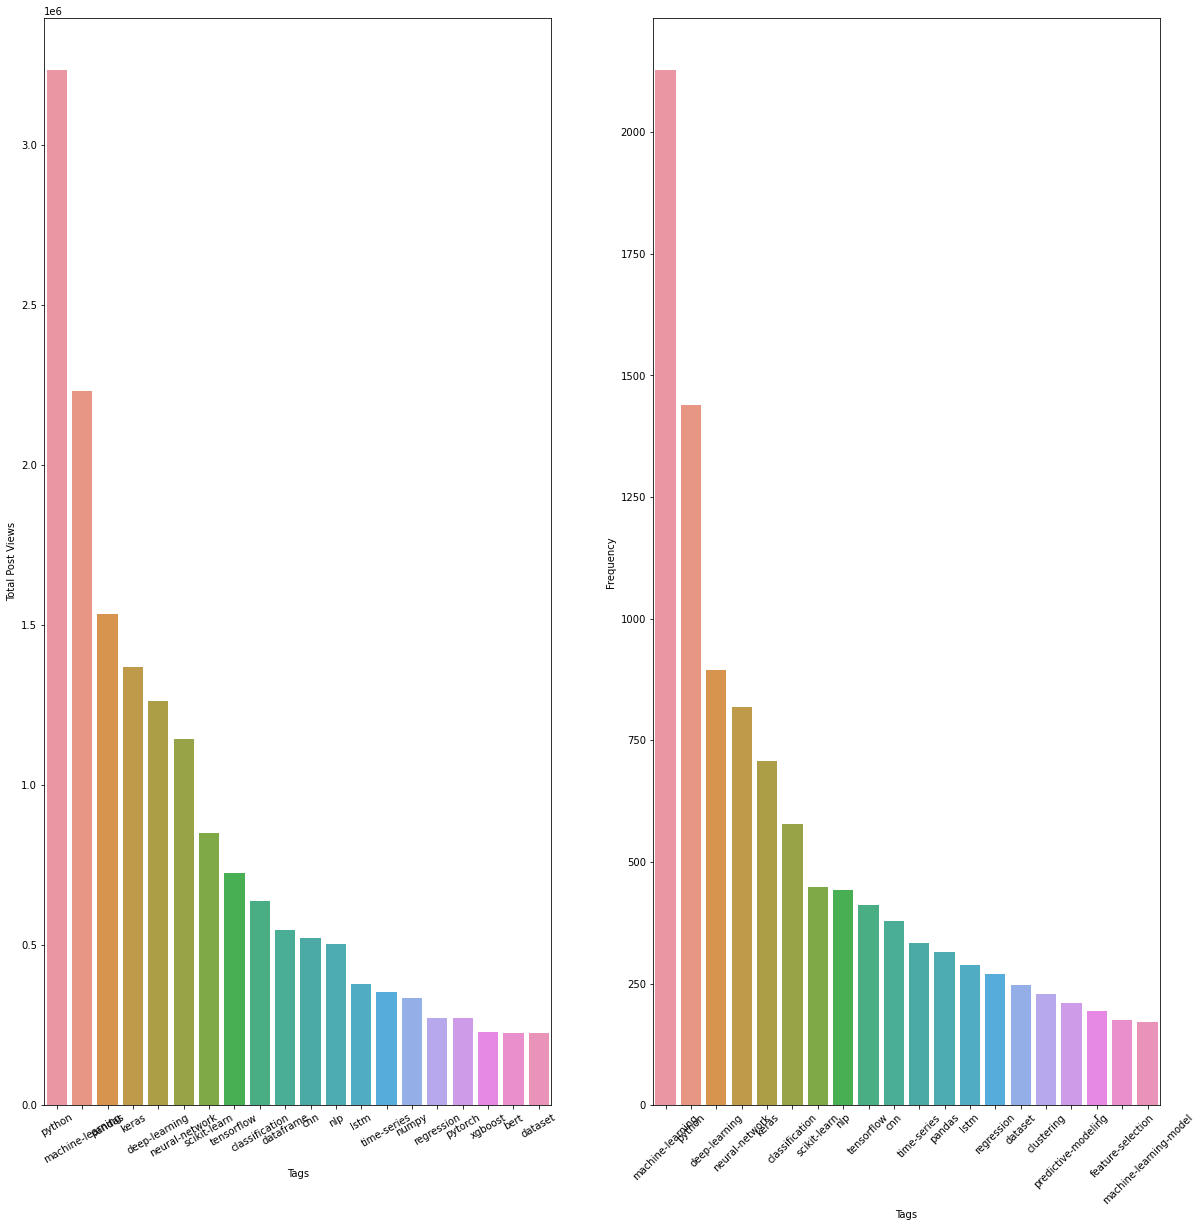

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

f,axs = plt.subplots(1, 2, figsize=(20,20))

ax0 = sns.barplot(data=tagsvideocount.sort_values(by=['viewcount_sum'],ascending=False).head(20),
                  x='tags',y='viewcount_sum',ax=axs[0])
ax0.set_xticklabels(ax0.get_xticklabels(),rotation = 30, size = 10)
ax0.set(xlabel='Tags', ylabel='Total Post Views')

ax1 = sns.barplot(data=tagsfreq.sort_values(by=['frequency'],ascending=False).head(20)
                  ,x='tags',y='frequency',ax=axs[1])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 45)
ax1.set(xlabel='Tags', ylabel='Frequency')

Interesting between frequency vs consumption on these graphs is that machine learning, in the realm of data science appears more with python second. Consumption wise, we see python viewed much more. This makes sense, because when tagging posts on forums, best practces would deem that its better for an user to tag their post with a broad category, i.e Python before specific tags to best maximize the posts reach.

## Part 2.2: Brainstorming

Think about technical solutions to determining how tags are related. We haven't covered any techniques to deal with this yet, so don't worry if nothing comes to mind.

1. We could first see if there are correlational relationships between certain tags and from there do some statistical tests to model relationships between pairs of tags. Although, at this time im not sure how to do this.

You may have noticed that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: `python`, `machine-learning`, `deep-learning`, `neural-network`, `keras`, `tensorflow`, `classification`, `scikit-learn`.

Do you know what each of these or most of these tags means? Could there be strong relations between them?

1. python is programmign language used for a variety of needs. in the data science space, it used for just that, and programmatically applying machine learning techniques. a lot of the other relate to deep-learning or artifical intelligence programming, with the names of some of the packages that enable these operations following.
2. there will be strong relations between these tags due to the sub-domain all being related to one another.

# Part 3: Providing Context to Our Analysis

Before we officially make our recommendation, it would be nice to solidify our findings with additional proof. 

More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? Back to SEDE!

Using the query:

    SELECT Id, CreationDate, Tags
      FROM posts
     WHERE PostTypeId = 1;
 
In this we will track the interest in deep learning across time. We will:

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

In [15]:
deeplearning = pd.read_csv('all_questions.csv',parse_dates=['CreationDate'])

#clean tags column
deeplearning['Tags']= deeplearning['Tags'].str.replace('(^\<)','',regex=True)
deeplearning['Tags'] = deeplearning['Tags'].str.replace('\>$','',regex=True)
deeplearning['Tags'] = deeplearning['Tags'].str.replace('\<','',regex=True)
deeplearning['Tags'] = deeplearning['Tags'].str.replace('\>',',',regex=True)
deeplearning['Tags'] = deeplearning['Tags'].str.split(',')

#creation of year column so that we can see how deep learning fairs over time
import datetime as dt
deeplearning['YearDate'] = deeplearning['CreationDate'].dt.year


In [16]:
deeplearning_array = ['deep-learning', 'neural-network', 'keras', 'tensorflow','scikit-learn']

def taginarray(list_):
    """
    Function that counts how many times a "deep-learning" string tag occurs. For this function, we are only counting 
    'deep-learning', 'neural-network', 'keras', 'tensorflow','scikit-learn' as "deep-learning tags" for simplicity.
    
    This function will be used via pd.Series.apply() method.
    
    """
    count = 0
    for item in list_:
        str(item)
        for dp in deeplearning_array:
            if item == dp:
                count += 1
            else:
                pass
    return count 


deeplearning['occurences_of_deeplearning_tags'] = deeplearning['Tags'].apply(taginarray)

In [28]:
#Now lets create a pivot table to see how many occurences of deep learning posts there are per year
#along with the total number of questions per that year
import numpy as np

deeplearningpivot = pd.pivot_table(
   deeplearning,
   index=['YearDate'],
   aggfunc={'YearDate': len, 'occurences_of_deeplearning_tags': np.sum }
).rename(columns={'YearDate': 'N_of_Questions','occurences_of_deeplearning_tags':'Tot_Deeplearning_questions'})

In [29]:
deeplearningpivot

,N_of_Questions,Tot_Deeplearning_questions
YearDate,,
2014,559,48
2015,1161,175
2016,2113,713
2017,2917,1425
2018,5326,3087
2019,6758,3281
2020,6143,2980
2021,5841,2626
2022,2728,1105


<AxesSubplot:xlabel='YearDate'>

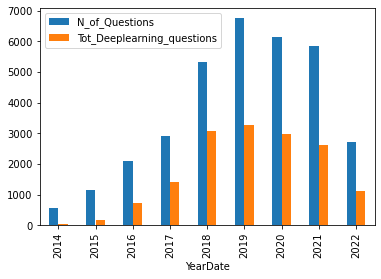

In [45]:
deeplearningpivot.plot(kind='bar')

# Conclusion

Overall trend for deep learning is a steady increase over time. Considering 2022 isnt over we can see that the demand for deep learning as increased for almost 5-6 years, still much too early to judge whether or not its here to stay forever, but we can say that demand is lasting over time. 

We also learned that Python and Machine learning are the top two tagged posts for data science, and that data science, machine learning, and deep-learning tags are all heavily connected. 

Deep learning is extremely popular and hopefully it will help make the world a better place.